In [69]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch

from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm

In [70]:
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

In [71]:
prompt = "The quick brown fox jumped over the"
inputs = tokenizer(prompt, return_tensors="pt")


def generate_token_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    return next_token_id, outputs.past_key_values


def generate(inputs, max_tokens):
    generated_tokens = []
    next_inputs = inputs
    for _ in range(max_tokens):
        next_token_id, past_key_values = \
        generate_token_with_past(next_inputs)
        next_inputs = {
            "input_ids": next_token_id.reshape((1, 1)),
            "attention_mask": torch.cat(
                [next_inputs["attention_mask"], torch.tensor([[1]])],
                dim=1
            ),
            "past_key_values": past_key_values,
        }

        next_token = tokenizer.decode(next_token_id)
        generated_tokens.append(next_token)
    return "".join(generated_tokens)


tokens = generate(inputs, max_tokens=10)
print(tokens)

 fence and ran to the other side of the fence


In [72]:
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

In [73]:
# Pad on the left so we can append new tokens on the right
tokenizer.padding_side = "left"
tokenizer.truncation_side = "left"

In [74]:
# Multiple prompts of varying lengths to send
# to the model at once
prompts = [
    "The quick brown fox jumped over the",
    "The rain in Spain falls",
    "What comes up must",
]

# Note: padding=True ensures the padding token
# will be inserted into the tokenized tensors
inputs = tokenizer(prompts, padding=True, return_tensors="pt")

In [75]:
print("input_ids:", inputs["input_ids"])
print("shape:", inputs["input_ids"].shape)

input_ids: tensor([[  464,  2068,  7586, 21831, 11687,   625,   262],
        [50256, 50256,   464,  6290,   287,  8602,  8953],
        [50256, 50256, 50256,  2061,  2058,   510,  1276]])
shape: torch.Size([3, 7])


In [76]:
print("attention_mask:", inputs["attention_mask"])
print("shape:", inputs["attention_mask"].shape)

attention_mask: tensor([[1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1]])
shape: torch.Size([3, 7])


In [77]:
# position_ids tell the transformer the ordinal position of each token in the input sequence# position_ids tell the transformer the ordinal position
# of each token in the input sequence
# for single input inference, this is just [0 .. n]
# for n tokens, but for batch inference,
# we need to 0 out the padding tokens at the start of the sequence
attention_mask = inputs["attention_mask"]
position_ids = attention_mask.long().cumsum(-1) - 1
position_ids.masked_fill_(attention_mask == 0, 1)

tensor([[0, 1, 2, 3, 4, 5, 6],
        [1, 1, 0, 1, 2, 3, 4],
        [1, 1, 1, 0, 1, 2, 3]])

In [78]:
# Same as before, but include the position_ids
with torch.no_grad():
    outputs = model(position_ids=position_ids, **inputs)
logits = outputs.logits

In [79]:
last_logits = logits[:, -1, :]
next_token_ids = last_logits.argmax(dim=1)

In [80]:
print(next_token_ids)

tensor([13990,   319,   307])


In [81]:
next_tokens = tokenizer.batch_decode(next_token_ids)
next_tokens

[' fence', ' on', ' be']

In [82]:
def generate_batch_tokens_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[:, -1, :]
    next_token_ids = last_logits.argmax(dim=1)
    return next_token_ids, outputs.past_key_values

In [83]:
def generate_batch(inputs, max_tokens):
    generated_tokens = [
        [] for _ in range(inputs["input_ids"].shape[0])
    ]

    attention_mask = inputs["attention_mask"]
    position_ids = attention_mask.long().cumsum(-1) - 1
    position_ids.masked_fill_(attention_mask == 0, 1)

    next_inputs = {
        "position_ids": position_ids,
        **inputs
    }

    for _ in range(max_tokens):
        next_token_ids, past_key_values = \
            generate_batch_tokens_with_past(next_inputs)

        next_inputs = {
            "input_ids": next_token_ids.reshape((-1, 1)),
            "position_ids": next_inputs["position_ids"][:, -1].unsqueeze(-1) + 1,
            "attention_mask": torch.cat([
                next_inputs["attention_mask"],
                torch.ones((next_token_ids.shape[0], 1)),
            ], dim=1),
            "past_key_values": past_key_values,
        }

        next_tokens = tokenizer.batch_decode(next_token_ids)
        for i, token in enumerate(next_tokens):
            generated_tokens[i].append(token)

    return ["".join(tokens) for tokens in generated_tokens]

In [84]:
generated_tokens = generate_batch(inputs, max_tokens=10)

In [85]:
for prompt, generated in zip(prompts, generated_tokens):
    print(prompt, f"\x1b[31m{generated}\x1b[0m\n")

The quick brown fox jumped over the  fence and ran to the other side of the fence

The rain in Spain falls  on the first day of the month, and the

What comes up must  be a good idea.

"I think



In [86]:
# constants
max_tokens = 10

# observations
durations = []
throughputs = []
latencies = []

batch_sizes = [2**p for p in range(13)]
for batch_size in batch_sizes:
    print(f"bs= {batch_size}")

    # generate tokens for batch and record duration
    t0 = time.time()
    batch_prompts = [
        prompts[i % len(prompts)] for i in range(batch_size)
    ]
    inputs = tokenizer(
        batch_prompts, padding=True, return_tensors="pt"
    )
    generated_tokens = generate_batch(inputs, max_tokens=max_tokens)
    duration_s = time.time() - t0

    ntokens = batch_size * max_tokens
    throughput = ntokens / duration_s
    avg_latency = duration_s / max_tokens
    print("duration", duration_s)
    print("throughput", throughput)
    print("avg latency", avg_latency)
    print()

    durations.append(duration_s)
    throughputs.append(throughput)
    latencies.append(avg_latency)

bs= 1
duration 0.30896782875061035
throughput 32.3658292853257
avg latency 0.030896782875061035

bs= 2
duration 0.28324079513549805
throughput 70.61129732541637
avg latency 0.028324079513549805

bs= 4
duration 0.3459970951080322
throughput 115.60790701872979
avg latency 0.034599709510803225

bs= 8
duration 0.48265504837036133
throughput 165.7498461273996
avg latency 0.048265504837036136

bs= 16
duration 0.5685176849365234
throughput 281.433637403671
avg latency 0.056851768493652345

bs= 32
duration 0.8161394596099854
throughput 392.08985208596675
avg latency 0.08161394596099854

bs= 64
duration 1.016422986984253
throughput 629.659116524797
avg latency 0.1016422986984253

bs= 128
duration 1.45542573928833
throughput 879.467749846097
avg latency 0.14554257392883302

bs= 256
duration 2.4441239833831787
throughput 1047.4100403271786
avg latency 0.24441239833831788

bs= 512
duration 4.699366092681885
throughput 1089.5086484053986
avg latency 0.4699366092681885

bs= 1024
duration 8.719222784

In [87]:
def render_plot(x, y1, y2, x_label, y1_label, y2_label):
    # Create a figure and a set of subplots
    fig, ax1 = plt.subplots()

    # Plot the first line (throughput)
    color = 'tab:red'
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y1_label, color=color)
    ax1.plot(x, y1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Set the x-axis to be log-scaled
    ax1.set_xscale('log', base=2)

    # Instantiate a second axes that shares the same x-axis
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel(y2_label, color=color)  # we already handled the x-label with ax1
    ax2.plot(x, y2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.show()

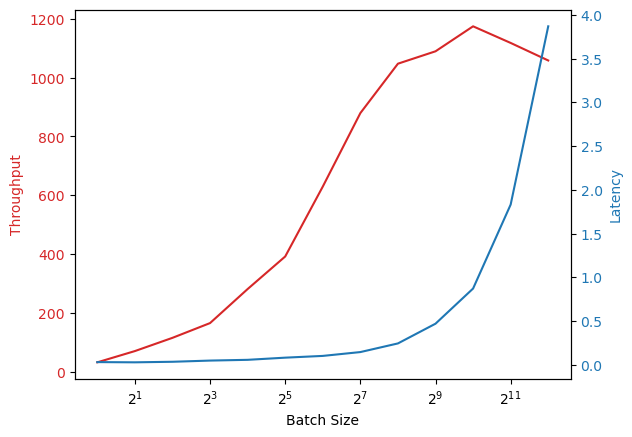

In [88]:
render_plot(
    batch_sizes,
    throughputs,
    latencies,
    "Batch Size",
    "Throughput",
    "Latency"
)